In [7]:
import numpy as np
import pandas as pd
from elasticsearch import Elasticsearch
from elasticsearch import helpers
import ipaddress
import random
from random import randrange

SIZE = 30000
OUTLIER_SIZE = 1500

def generateIP():
    blockOne = randrange(0, 255, 1)
    blockTwo = randrange(0, 255, 1)
    blockThree = randrange(0, 255, 1)
    blockFour = randrange(0, 255, 1)

    return str(blockOne) + '.' + str(blockTwo) + '.' + str(blockThree) + '.' + str(blockFour)

def generate(median=630, err=12, outlier_err=400, size=SIZE, outlier_size=OUTLIER_SIZE):

    # Generate flow logs <float>
    flow_errs = err * np.random.rand(size) * np.random.choice((-1, 1), size)
    flow_good = median + flow_errs

    flow_lower_errs = outlier_err * np.random.rand(outlier_size)
    flow_lower_outliers = median - err -flow_lower_errs

    flow_upper_errs = outlier_err * np.random.rand(outlier_size)
    flow_upper_outliers = median + err + flow_upper_errs

    # Generate session logs <int>    
    sessions_good = np.random.rand(size) * 10 + 1
    sessions_good = np.round(sessions_good,0)

    sessions_lower_outliers = np.random.rand(outlier_size) * 1 + 1
    sessions_lower_outliers = np.round(sessions_lower_outliers,0)

    sessions_upper_outliers = np.random.rand(outlier_size) * 1000
    sessions_upper_outliers = np.round(sessions_upper_outliers,0)

    # Combine np.array 

    combined_good = np.vstack((flow_good, sessions_good)).T 
    combined_lower = np.vstack((flow_lower_outliers, sessions_lower_outliers)).T
    combined_upper = np.vstack((flow_upper_outliers, sessions_upper_outliers)).T

    data = np.concatenate((combined_good, combined_lower, combined_upper))
    #np.random.shuffle(data)

    return data

In [8]:
df = pd.DataFrame(data=generate())
# "nb_sessions", "nb_src_ip", "nb_dest_ip", "sum_url", "sum_bytes_toclient", "sum_bytes_toserver", "ratio_server_client"

In [9]:
%time
df['source_ip'] = '190.166.13.79'
for i in df.index:
    if i < SIZE:
        df.loc[i, 'source_ip'] = '192.11.13.'+ str(random.randrange(150, 180))
    else:
        df.loc[i, 'source_ip'] = generateIP()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


In [11]:
df['outliers'] = 0
df[SIZE:]['outliers'] = 1

In [12]:
df = df.rename(columns = {0 : "sum_bytes_toclient", 1 : "nb_sessions"})
df['sum_bytes_toclient'] = df['sum_bytes_toclient'].round(0)
df = df.astype({'sum_bytes_toclient': int, 'nb_sessions': int, 'source_ip': str})
df = df.sample(frac=1).reset_index(drop=True)

In [13]:
df['ts'] = pd.date_range("2021-02-15 6:28:00", periods= SIZE + OUTLIER_SIZE * 2 , freq="min")
df['id'] = np.linspace(1, SIZE + OUTLIER_SIZE*2, SIZE + OUTLIER_SIZE*2)

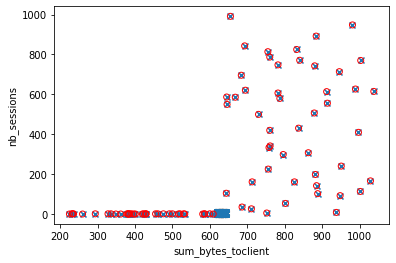

In [63]:
import matplotlib.pyplot as plt
SET_PLOT_NUMBER = 1000
df_out = df.loc[:SET_PLOT_NUMBER,'outliers'].where((df['outliers'] == 1)).dropna()
idx_list = list(df_out.index.values)

plt.scatter(df.iloc[0:SET_PLOT_NUMBER,0], df.iloc[0:SET_PLOT_NUMBER,1], marker = "x")
plt.xlabel('sum_bytes_toclient')
plt.ylabel('nb_sessions')
plt.scatter(df.iloc[idx_list,0], df.iloc[idx_list,1], facecolors = 'none', edgecolors = 'r')

In [123]:
use_these_keys = ['sum_bytes_toclient', 'nb_sessions', 'source_ip', 'outliers','ts','id']
def filterKeys(document):
    return {key: document[key] for key in use_these_keys }

In [106]:
es_client = Elasticsearch(http_compress=True)
def doc_generator(df):
    df_iter = df.iterrows()
    for index, document in df_iter:
        yield {
                "_index": 'anomaly_example',
                "_type": "_doc",
                "_id" : f"{document['id']}",
                "_source": filterKeys(document),
            }
    raise StopIteration
helpers.bulk(es_client, doc_generator(df))

(33000, [])